Ignore colab import if running locally

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace `csv` with the path to any file in the `data` directory with format `{ticker_name}/stock_with_sentiment.csv`

In [2]:
import pandas as pd
csv = "/content/drive/MyDrive/WPI/Senior Year/CS539 (ML)/AAPL_stock_with_sentiment.csv"
df = pd.read_csv(csv)
print(len(df))

488


# Add Additional Features (Optional)

In [ ]:
# # Moving averages
# df['sma50'] = df['Close'].rolling(window=50).mean()  # Simple Moving Average (SMA) over 50 days
# df['sma21'] = df['Close'].rolling(window=21).mean()  # SMA over 21 days
# df['ema50'] = df['Close'].ewm(span=50, min_periods=0, adjust=False).mean()  # Exponential Moving Average (EMA) over 50 days
# df['ema21'] = df['Close'].ewm(span=21, min_periods=0, adjust=False).mean()  # EMA over 21 days

# # Lag features (past price data)
# lag_days = [1, 3, 5]
# for lag_day in lag_days:
#     df[f'lag_{lag_day}'] = df['Close'].shift(lag_day)  # Lagged Close price for 'lag_day' days

# # Calculate percentage change features
# df['pct_change'] = df['Close'].pct_change()  # Percentage change from the previous day's close
# df['vol_pct_change'] = df['Volume'].pct_change()  # Percentage change in volume from the previous day

# df.dropna(inplace=True)

# Create the target labels for each row to indicate whether the stock will have uptrend/downtrend for next day

In [3]:
# get uptrend/downtrend labels for individual stocks
df['Adj Close Next'] = df['Adj Close'].shift(-1)
df['Label'] = df.apply(lambda x: 1 if (x['Adj Close Next'] >= x['Adj Close']) else 0, axis =1)
# check class balancing
print(df['Label'].value_counts())

Label
1    254
0    234
Name: count, dtype: int64


# Preprocess the Data for Training

In [4]:
# seed everything
import numpy as np
seed = 42
np.random.seed(42)

In [7]:
from sklearn.preprocessing import StandardScaler

# Train/Test split = Cannot randomly split for time series data as this would introduce look-ahead bias
num_test_days = int(len(df)*0.2)
dates = df['Date'].unique()
split = len(dates) - num_test_days
train_dates = dates[:split]
test_dates = dates[split:]

train_df = df[df['Date'].isin(train_dates)]
test_df = df[df['Date'].isin(test_dates)]

print(train_df['Label'].value_counts(),
      test_df['Label'].value_counts())

# Create target data set
y_train = np.array(train_df['Label'])
y_test = np.array(test_df['Label'])

# only include relevant features
continuous_features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
                       'mean_neg_sentiment_prob', 'mean_neu_sentiment_prob', 'mean_pos_sentiment_prob']

# continuous_features += ['sma50', 'sma21', 'ema50', 'ema21', 'lag_1', 'lag_3', 'lag_5', 'pct_change', 'vol_pct_change']

count_features = ['neg_sentiment_cnt', 'neu_sentiment_cnt', 'pos_sentiment_cnt']

# Create separate training and testing sets for each model
X_train = train_df[continuous_features + count_features]
X_test = test_df[continuous_features + count_features]

print(X_train.columns)

# Assuming X_train_continuous and X_test_continuous are correctly defined somewhere in your code:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Make sure X_test_continuous is defined

Label
1    198
0    193
Name: count, dtype: int64 Label
1    56
0    41
Name: count, dtype: int64
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'mean_neg_sentiment_prob', 'mean_neu_sentiment_prob',
       'mean_pos_sentiment_prob', 'neg_sentiment_cnt', 'neu_sentiment_cnt',
       'pos_sentiment_cnt'],
      dtype='object')


# Training Models
RandomSearch is used here to tune model hyperparameters.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, make_scorer


def train(model, X_train, y_train, tuning_params, seed):
    """
    Trains models and tunes hyperparams via RandomSearchCV
    Returns the best estimator and best params
    """
    rs = RandomizedSearchCV(
        model,
        tuning_params,
        random_state=seed,
        # scoring='accuracy',
        scoring=make_scorer(matthews_corrcoef),
        cv=5,
    )
    results = rs.fit(X_train, y_train)
    return results.best_estimator_, results.best_params_


def test(model, X_test, y_test):
    """
    Tests model
    Prints classification report and confusion matrix
    """
    # Final Classification Report
    y_pred = model.predict(X_test)
    labels = ['Downtrend', 'Uptrend']

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=labels))
    print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}")
    print(f"MCC Score: {matthews_corrcoef(y_true=y_test, y_pred=y_pred)}")

    # confusion matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    disp.plot()
    plt.show()

In [9]:
from scipy.stats import randint, uniform
# specify the hyperparameters to tune for each model

rf_params = {
    "n_estimators": randint(low=50, high=500),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": randint(low=1, high=50),
    "max_features": randint(low=1, high=X_train.shape[1]),
    "bootstrap": [False, True],
    "warm_start": [False, True],
}

rf_params = {
    "n_estimators": randint(low=100, high=500),
    "criterion": ["gini", "entropy"],
    "max_depth": randint(low=10, high=50),
    "max_features": randint(low=1, high=10),
    "bootstrap": [True],
}
ada_params = {
    "n_estimators": randint(low=50, high=500),
    "learning_rate": uniform(loc=0.0001, scale=1),
    "algorithm": ["SAMME", "SAMME.R"],
}
log_reg_params = {
    'C': uniform(loc=0, scale=4),
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': randint(low=50, high=500),
    'penalty': ['l1', 'l2', None]
}
gb_params = {
    "loss": ['log_loss', 'exponential'],
    "learning_rate": uniform(loc=0.0001, scale=1),
    "n_estimators": randint(low=50, high=500),
    "subsample": uniform(0.0, 1.0),
    "criterion": ["friedman_mse", "squared_error"],
    "warm_start": [False, True],
    "max_depth": randint(low=1, high=50),
    "max_features": randint(low=1, high=X_train.shape[1]),
}
svm_params = {
    'C': uniform(loc=0.1, scale=10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 10),
    'gamma': ['scale', 'auto'] + list(uniform(loc=0.1, scale=1).rvs(size=10)),
    'shrinking': [True, False],
    'probability': [True, False],
    'tol': uniform(loc=1e-4, scale=1e-2),
    'class_weight': [None, 'balanced'],
    'max_iter': randint(50, 500)
}
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None] + list(randint(1, 20).rvs(size=10)),
    'class_weight': [None, 'balanced']
}

In [10]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

# # Feature Selection
# selector = RFE(RandomForestClassifier(random_state=seed), n_features_to_select=10)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

# specify the models to try
models = {
    "RandomForest": (RandomForestClassifier(random_state=seed), rf_params),
    "AdaBoost": (AdaBoostClassifier(random_state=seed), ada_params),
    "GradientBoosting": (GradientBoostingClassifier(random_state=seed), gb_params),
    "LogisticRegression": (LogisticRegression(random_state=seed), log_reg_params),
    "GaussianNB": (GaussianNB(), {}),
    "SVM": (SVC(random_state=seed), svm_params),
    "DecisionTree": (DecisionTreeClassifier(random_state=seed), dt_params),
}



Results for DecisionTree:
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 14, 'min_samples_split': 18, 'splitter': 'random'}
              precision    recall  f1-score   support

   Downtrend       0.55      0.41      0.47        41
     Uptrend       0.64      0.75      0.69        56

    accuracy                           0.61        97
   macro avg       0.59      0.58      0.58        97
weighted avg       0.60      0.61      0.60        97

Accuracy: 0.6082474226804123
MCC Score: 0.17440263540470408


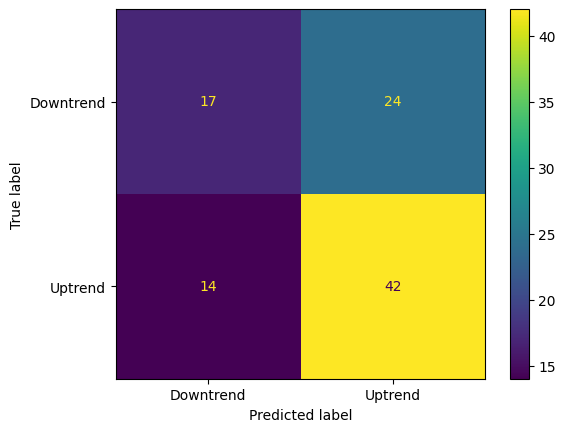

In [11]:
# tune each model
for name, (model, params) in models.items():
    print(f"Results for {name}:")
    best_estimator, best_params = train(model, X_train, y_train, params, seed)
    print(f"Best params: {best_params}")
    test(best_estimator, X_test, y_test)

# Deep Learning Models

Epoch 1, Train Loss: 0.7012358188629151, Val Loss: 0.6953668594360352, Val F1: 0.3700159489633174, Model improved and saved.
Epoch 2, Train Loss: 0.6861335635185242, Val Loss: 0.7058685719966888, Val F1: 0.5424710424710424, Model improved and saved.
Epoch 3, Train Loss: 0.691069483757019, Val Loss: 0.7401237487792969, Val F1: 0.5316455696202531
Epoch 4, Train Loss: 0.6697142839431762, Val Loss: 0.7483834624290466, Val F1: 0.5558232931726907, Model improved and saved.
Epoch 5, Train Loss: 0.6703243970870971, Val Loss: 0.773927628993988, Val F1: 0.5313451980118646
Epoch 6, Train Loss: 0.6557446360588074, Val Loss: 0.7365573346614838, Val F1: 0.5812048192771084, Model improved and saved.
Epoch 7, Train Loss: 0.6439536452293396, Val Loss: 0.729632705450058, Val F1: 0.6075949367088608, Model improved and saved.
Epoch 8, Train Loss: 0.63629549741745, Val Loss: 0.7868040502071381, Val F1: 0.5442307692307693
Epoch 9, Train Loss: 0.6488947033882141, Val Loss: 0.7867554426193237, Val F1: 0.47967

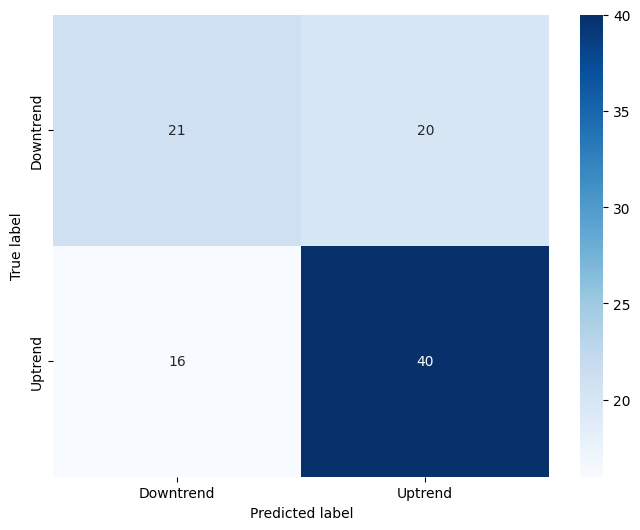

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau, CyclicLR
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix
from matplotlib import pyplot as plt
from torch.nn.utils import clip_grad_norm_
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Assume you've already split your data into train_df and test_df

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[continuous_features + count_features])
X_test = scaler.transform(test_df[continuous_features + count_features])

# Create target datasets
y_train = train_df['Label'].values
y_test = test_df['Label'].values

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create tensor datasets
train_val_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Test dataset and loader remain the same
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class EnhancedStockNet(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedStockNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.1)

        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.dropout6 = nn.Dropout(0.1)

        self.fc7 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dropout5(x)

        x = F.relu(self.bn6(self.fc6(x)))
        x = self.dropout6(x)

        x = self.fc7(x)
        return x

input_dim = X_train.shape[1]
nn_model = EnhancedStockNet(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

def train_model(num_epochs=50, patience=15, max_grad_norm=2):
    best_f1 = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = nn_model(data)
            loss = criterion(output, target)
            loss.backward()
            clip_grad_norm_(nn_model.parameters(), max_grad_norm)
            optimizer.step()
            total_loss += loss.item()

        val_loss = 0
        val_targets = []
        val_outputs = []
        nn_model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                output = nn_model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                val_targets.extend(target.tolist())
                val_outputs.extend(predicted.tolist())

        val_loss /= len(val_loader)
        val_f1 = f1_score(val_targets, val_outputs, average='macro')
        # scheduler.step()  # Adjusted to step after each epoch without parameters

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(nn_model.state_dict(), 'best_model.pth')
            print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader)}, Val Loss: {val_loss}, Val F1: {val_f1}, Model improved and saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader)}, Val Loss: {val_loss}, Val F1: {val_f1}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

def evaluate_model():
    nn_model.load_state_dict(torch.load('best_model.pth'))
    nn_model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for data, target in test_loader:
            outputs = nn_model(data)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(target.tolist())
    labels = ['Downtrend', 'Uptrend']
    print(classification_report(y_true, y_pred, target_names=labels))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.3f}")

    # Plotting Confusion Matrix in the style of scikit-learn's ConfusionMatrixDisplay
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.show()

# Define the get_nn_predictions function
def get_nn_predictions(nn_model, data_loader):
    nn_model.eval()  # Set the model to evaluation mode
    all_preds = []
    with torch.no_grad():
        for data, _ in data_loader:
            outputs = nn_model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)



train_model()
evaluate_model()


#Ensemble


Best params for RandomForest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 8, 'n_estimators': 472}
Results for RandomForest:
              precision    recall  f1-score   support

   Downtrend       0.40      0.76      0.53        38
     Uptrend       0.55      0.20      0.30        54

    accuracy                           0.43        92
   macro avg       0.48      0.48      0.41        92
weighted avg       0.49      0.43      0.39        92

Accuracy: 0.43478260869565216
MCC Score: -0.03955842467199346


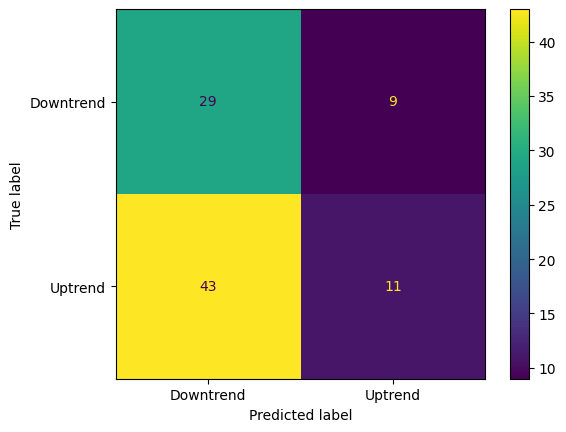

Best params for AdaBoost: {'algorithm': 'SAMME.R', 'learning_rate': 0.9386527090157502, 'n_estimators': 435}
Results for AdaBoost:
              precision    recall  f1-score   support

   Downtrend       0.42      0.71      0.53        38
     Uptrend       0.61      0.31      0.41        54

    accuracy                           0.48        92
   macro avg       0.51      0.51      0.47        92
weighted avg       0.53      0.48      0.46        92

Accuracy: 0.4782608695652174
MCC Score: 0.027117251109095273


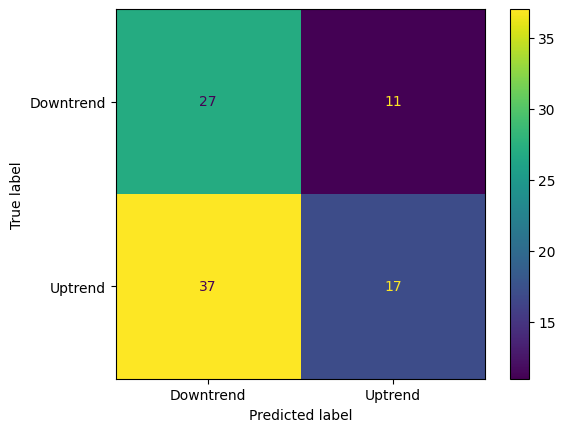

Best params for GradientBoosting: {'criterion': 'friedman_mse', 'learning_rate': 0.8423847745949985, 'loss': 'exponential', 'max_depth': 34, 'max_features': 10, 'n_estimators': 495, 'subsample': 0.9266588657937942, 'warm_start': False}
Results for GradientBoosting:
              precision    recall  f1-score   support

   Downtrend       0.38      0.63      0.48        38
     Uptrend       0.52      0.28      0.36        54

    accuracy                           0.42        92
   macro avg       0.45      0.45      0.42        92
weighted avg       0.46      0.42      0.41        92

Accuracy: 0.42391304347826086
MCC Score: -0.0960627449656615


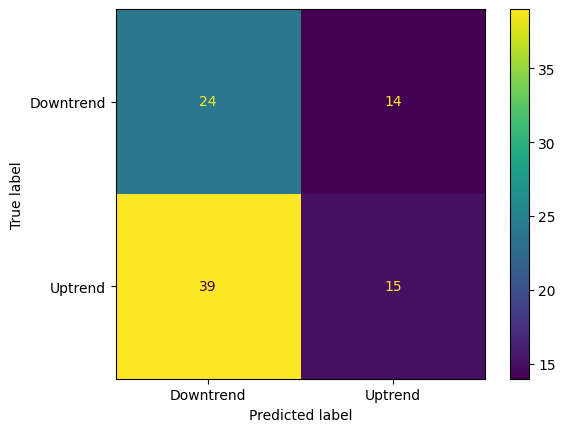

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

Best params for LogisticRegression: {'C': 0.22564631610840102, 'max_iter': 393, 'penalty': 'l2', 'solver': 'liblinear'}
Results for LogisticRegression:
              precision    recall  f1-score   support

   Downtrend       0.42      0.92      0.58        38
     Uptrend       0.67      0.11      0.19        54

    accuracy                           0.45        92
   macro avg       0.54      0.52      0.38        92
weighted avg       0.57      0.45      0.35        92

Accuracy: 0.44565217391304346
MCC Score: 0.05330831513540311


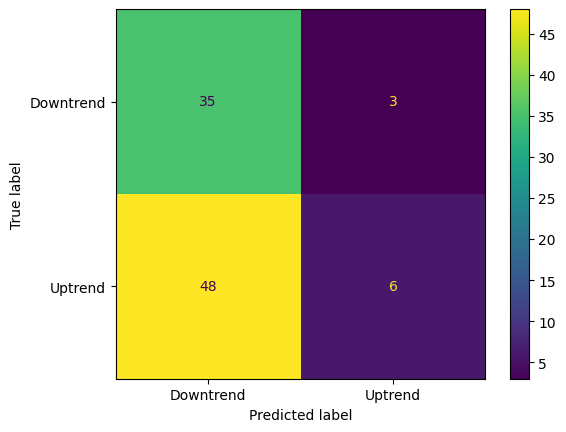

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined

Best params for GaussianNB: {}
Results for GaussianNB:
              precision    recall  f1-score   support

   Downtrend       0.41      1.00      0.58        38
     Uptrend       0.00      0.00      0.00        54

    accuracy                           0.41        92
   macro avg       0.21      0.50      0.29        92
weighted avg       0.17      0.41      0.24        92

Accuracy: 0.41304347826086957
MCC Score: 0.0


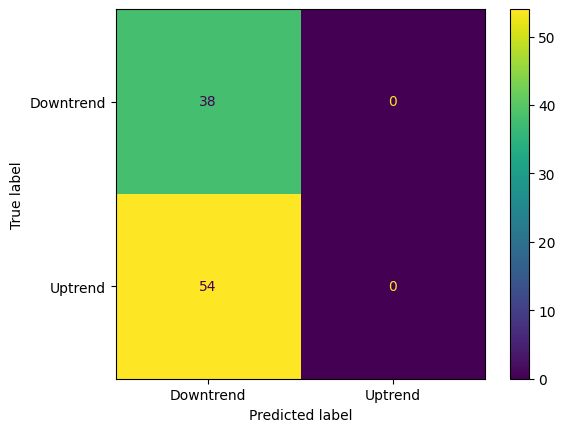

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=171).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=171).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=171).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=171).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=171).  Consider pre-

Best params for SVM: {'C': 9.485527090157502, 'class_weight': 'balanced', 'degree': 5, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': 363, 'probability': False, 'shrinking': True, 'tol': 0.004419450186421158}
Results for SVM:
              precision    recall  f1-score   support

   Downtrend       0.00      0.00      0.00        38
     Uptrend       0.58      0.98      0.73        54

    accuracy                           0.58        92
   macro avg       0.29      0.49      0.37        92
weighted avg       0.34      0.58      0.43        92

Accuracy: 0.5760869565217391
MCC Score: -0.08793752175839238


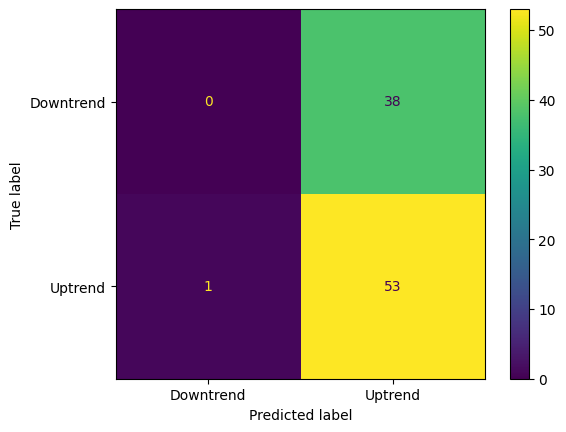

Best params for DecisionTree: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 16, 'splitter': 'random'}
Results for DecisionTree:
              precision    recall  f1-score   support

   Downtrend       0.38      0.47      0.42        38
     Uptrend       0.56      0.46      0.51        54

    accuracy                           0.47        92
   macro avg       0.47      0.47      0.46        92
weighted avg       0.48      0.47      0.47        92

Accuracy: 0.4673913043478261
MCC Score: -0.062402140679751444


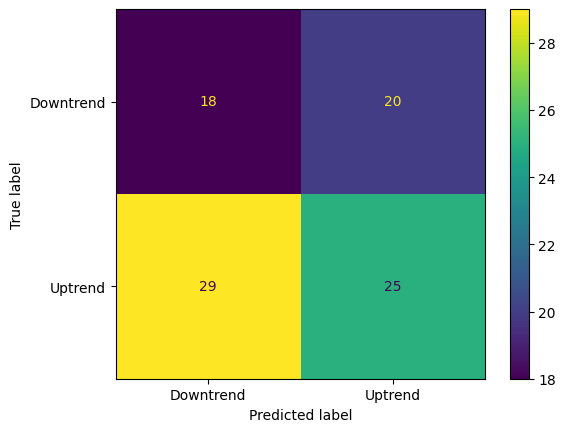

The best model is SVM with an accuracy of 0.576.

Model Performance Overview:
RandomForest: Accuracy = 0.435
AdaBoost: Accuracy = 0.478
GradientBoosting: Accuracy = 0.424
LogisticRegression: Accuracy = 0.446
GaussianNB: Accuracy = 0.413
SVM: Accuracy = 0.576
DecisionTree: Accuracy = 0.467
NeuralNetwork: Accuracy = 0.435


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize dictionary to store model predictions and accuracies
model_predictions = {}
model_accuracies = {}

def test_and_store_results(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_predictions[model_name] = y_pred
    model_accuracies[model_name] = accuracy

    labels = ['Downtrend', 'Uptrend']
    print(f"Results for {model_name}:")
    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=labels))
    print(f"Accuracy: {accuracy}")
    print(f"MCC Score: {matthews_corrcoef(y_true=y_test, y_pred=y_pred)}")
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    disp.plot()
    plt.show()

# Assuming models and test data are already defined
for name, (model, params) in models.items():
    best_estimator, best_params = train(model, X_train, y_train, params, seed)
    print(f"Best params for {name}: {best_params}")
    test_and_store_results(best_estimator, X_test, y_test, name)
# Function to store NN model predictions (assuming 'nn_model' is the NN model and correctly trained)
def get_nn_predictions(nn_model, data_loader):
    nn_model.eval()
    all_preds = []
    with torch.no_grad():
        for data, _ in data_loader:
            outputs = nn_model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)
# Assuming nn_model and test_loader are correctly defined and available
nn_preds = get_nn_predictions(nn_model, test_loader)
model_predictions['NeuralNetwork'] = nn_preds
model_accuracies['NeuralNetwork'] = accuracy_score(y_test, nn_preds)

# Find the best performing model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]

print(f"The best model is {best_model_name} with an accuracy of {best_model_accuracy:.3f}.")

# Optionally, display all model performances
print("\nModel Performance Overview:")
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: Accuracy = {accuracy:.3f}")


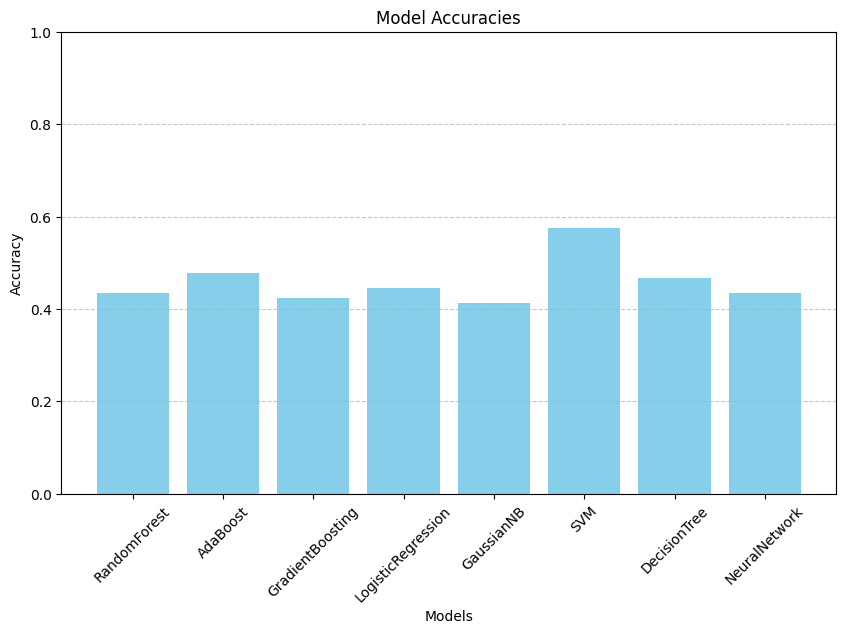

In [ ]:
# Extract model names and accuracies
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Add Neural Network accuracy if available
if 'NeuralNetwork' in model_accuracies:
    model_names.append('NeuralNetwork')
    accuracies.append(model_accuracies['NeuralNetwork'])

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()